In [1]:
%reset -s -f

In [2]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [3]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

D:\Programs\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Programs\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


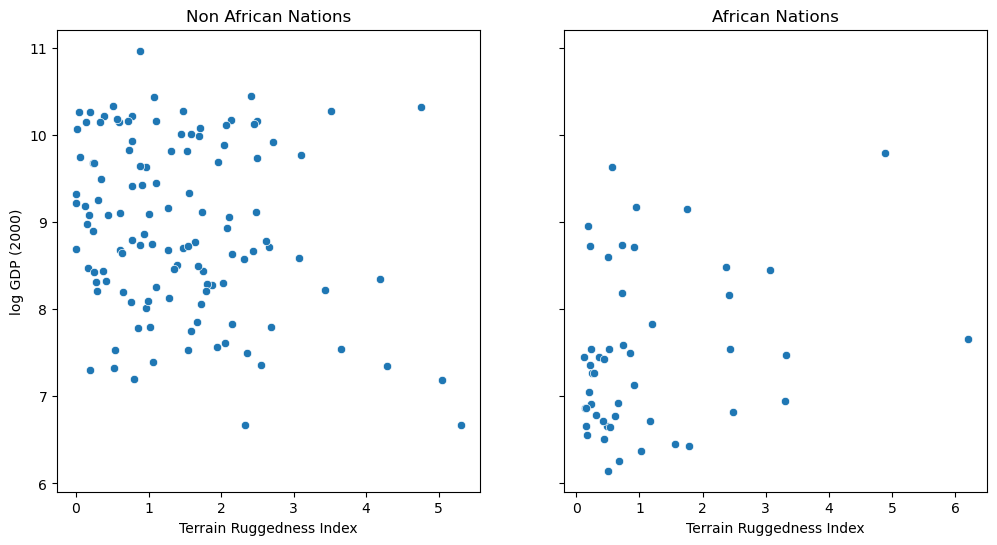

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [5]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [6]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7847
[iteration 0100] loss: 1616.1371
[iteration 0150] loss: 1109.4115
[iteration 0200] loss: 833.7544
[iteration 0250] loss: 637.5822
[iteration 0300] loss: 488.2652
[iteration 0350] loss: 376.4650
[iteration 0400] loss: 296.0483
[iteration 0450] loss: 240.6140
[iteration 0500] loss: 203.9385
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3493
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

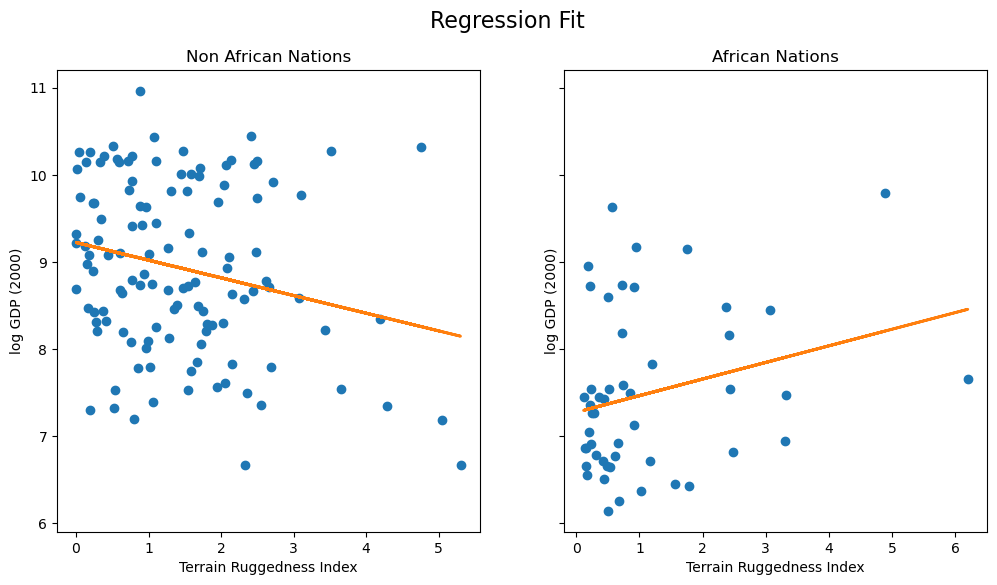

In [7]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [8]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [9]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [10]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [11]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5269
[iteration 0201] loss: 3.2377
[iteration 0301] loss: 3.0867
[iteration 0401] loss: 2.6374
[iteration 0501] loss: 2.0617
[iteration 0601] loss: 1.4856
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4939
[iteration 1101] loss: 1.4989
[iteration 1201] loss: 1.4937
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


In [12]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9327, 0.9647, 0.9976]),
 'linear.weight': tensor([[[-1.8868, -0.1952,  0.3272]],
 
         [[-1.8097, -0.1691,  0.3790]],
 
         [[-1.7325, -0.1430,  0.4309]]]),
 'linear.bias': tensor([[9.1351],
         [9.1824],
         [9.2296]])}

In [13]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [14]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

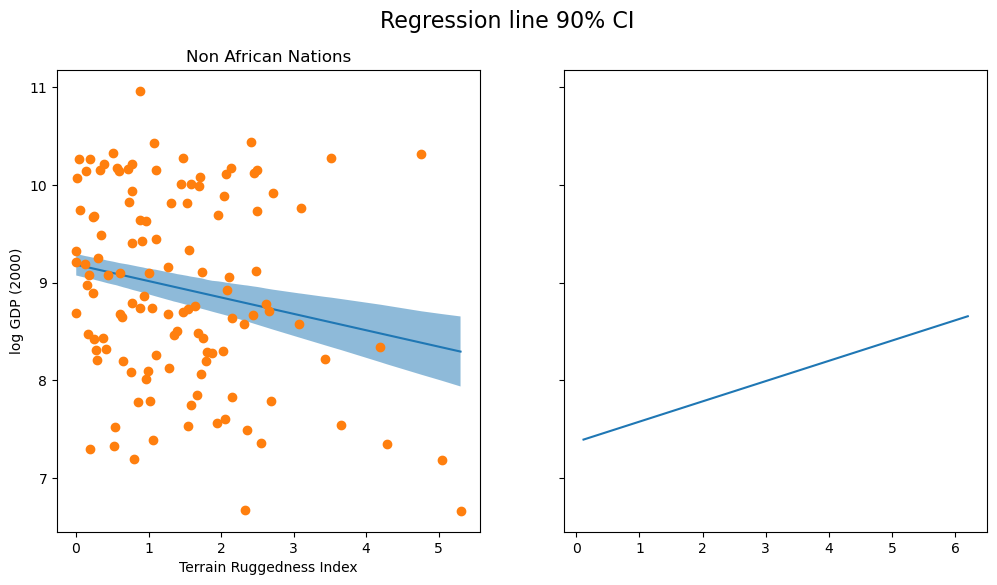

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between([t.item() for t in non_african_nations["rugged"]],
                   [t.item() for t in non_african_nations["mu_perc_5"]],
                   [t.item() for t in non_african_nations["mu_perc_95"]],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between([t.item() for t in african_nations["rugged"]],
                   [t.item() for t in african_nations["mu_perc_5"]],
                   [t.item() for t in african_nations["mu_perc_95"]],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [16]:
non_african_nations["rugged"]

41     tensor(0.0030)
85     tensor(0.0060)
5      tensor(0.0060)
136    tensor(0.0160)
115    tensor(0.0370)
            ...      
89     tensor(4.1970)
83     tensor(4.2870)
26     tensor(4.7610)
117    tensor(5.0430)
149    tensor(5.3010)
Name: rugged, Length: 121, dtype: object

In [17]:
non_african_nations["mu_mean"]

41     tensor(9.1842)
85     tensor(9.1837)
5      tensor(9.1837)
136    tensor(9.1820)
115    tensor(9.1785)
            ...      
89     tensor(8.4802)
83     tensor(8.4651)
26     tensor(8.3855)
117    tensor(8.3382)
149    tensor(8.2949)
Name: mu_mean, Length: 121, dtype: object

In [18]:
non_african_nations["mu_perc_5"]

41     tensor(9.0735)
85     tensor(9.0730)
5      tensor(9.0730)
136    tensor(9.0712)
115    tensor(9.0675)
            ...      
89     tensor(8.1861)
83     tensor(8.1646)
26     tensor(8.0582)
117    tensor(7.9967)
149    tensor(7.9379)
Name: mu_perc_5, Length: 121, dtype: object

In [19]:
[t.item() for t in non_african_nations["mu_perc_5"]]

[9.07352066040039,
 9.072989463806152,
 9.072989463806152,
 9.071216583251953,
 9.06749439239502,
 9.063987731933594,
 9.05224895477295,
 9.048704147338867,
 9.046753883361816,
 9.045437812805176,
 9.04411506652832,
 9.042791366577148,
 9.042430877685547,
 9.0349760055542,
 9.033181190490723,
 9.032183647155762,
 9.032183647155762,
 9.026107788085938,
 9.023982048034668,
 9.021738052368164,
 9.015910148620605,
 9.012564659118652,
 9.007325172424316,
 9.004107475280762,
 8.998470306396484,
 8.994644165039062,
 8.98090934753418,
 8.97850513458252,
 8.976799964904785,
 8.971375465393066,
 8.964648246765137,
 8.963255882263184,
 8.962717056274414,
 8.956969261169434,
 8.953104972839355,
 8.940690994262695,
 8.936845779418945,
 8.931417465209961,
 8.92847728729248,
 8.927572250366211,
 8.927120208740234,
 8.927120208740234,
 8.922203063964844,
 8.911991119384766,
 8.906067848205566,
 8.905433654785156,
 8.905221939086914,
 8.899086952209473,
 8.893586158752441,
 8.888355255126953,
 8.887527